# **Anomaly Detection**

In [ ]:
import pandas as pd
import datetime
import random
import os

# Settings
output_file = 'hardware_monitor_data.csv'
target_size_gb = 1  # Target size in GB
target_size_bytes = target_size_gb * 1024 * 1024 * 1024  # Convert GB to bytes
batch_size = 10000  # Number of records per batch

# Function to generate synthetic data
def generate_batch(batch_size):
    data = {
        'timestamp': [datetime.datetime.now() for _ in range(batch_size)],
        'cpu_temperature': [random.uniform(30, 90) for _ in range(batch_size)],
        'cpu_usage': [random.uniform(0, 100) for _ in range(batch_size)],
        'cpu_load': [random.uniform(0, 10) for _ in range(batch_size)],
        'memory_usage': [random.uniform(10, 100) for _ in range(batch_size)],
        'battery_level': [random.uniform(0, 100) for _ in range(batch_size)],
        'cpu_power': [random.uniform(10, 50) for _ in range(batch_size)],
        'disk_usage': [random.uniform(10, 100) for _ in range(batch_size)],
        'network_sent': [random.uniform(10, 100) for _ in range(batch_size)],
        'network_recv': [random.uniform(10, 100) for _ in range(batch_size)],
    }
    return pd.DataFrame(data)

# Initialize the file if it doesn't exist
if not os.path.exists(output_file):
    df_init = generate_batch(1)  # Create a single record to initialize file
    df_init.to_csv(output_file, mode='w', index=False)

# Keep appending data until the file size reaches 1 GB
while os.path.getsize(output_file) < target_size_bytes:
    df_batch = generate_batch(batch_size)  # Generate a batch of data
    df_batch.to_csv(output_file, mode='a', header=False, index=False)  # Append to CSV

# Display final file size
file_size_mb = os.path.getsize(output_file) / (1024 * 1024)
print(f"Final file size: {file_size_mb:.2f} MB")

Final file size: 1024.69 MB


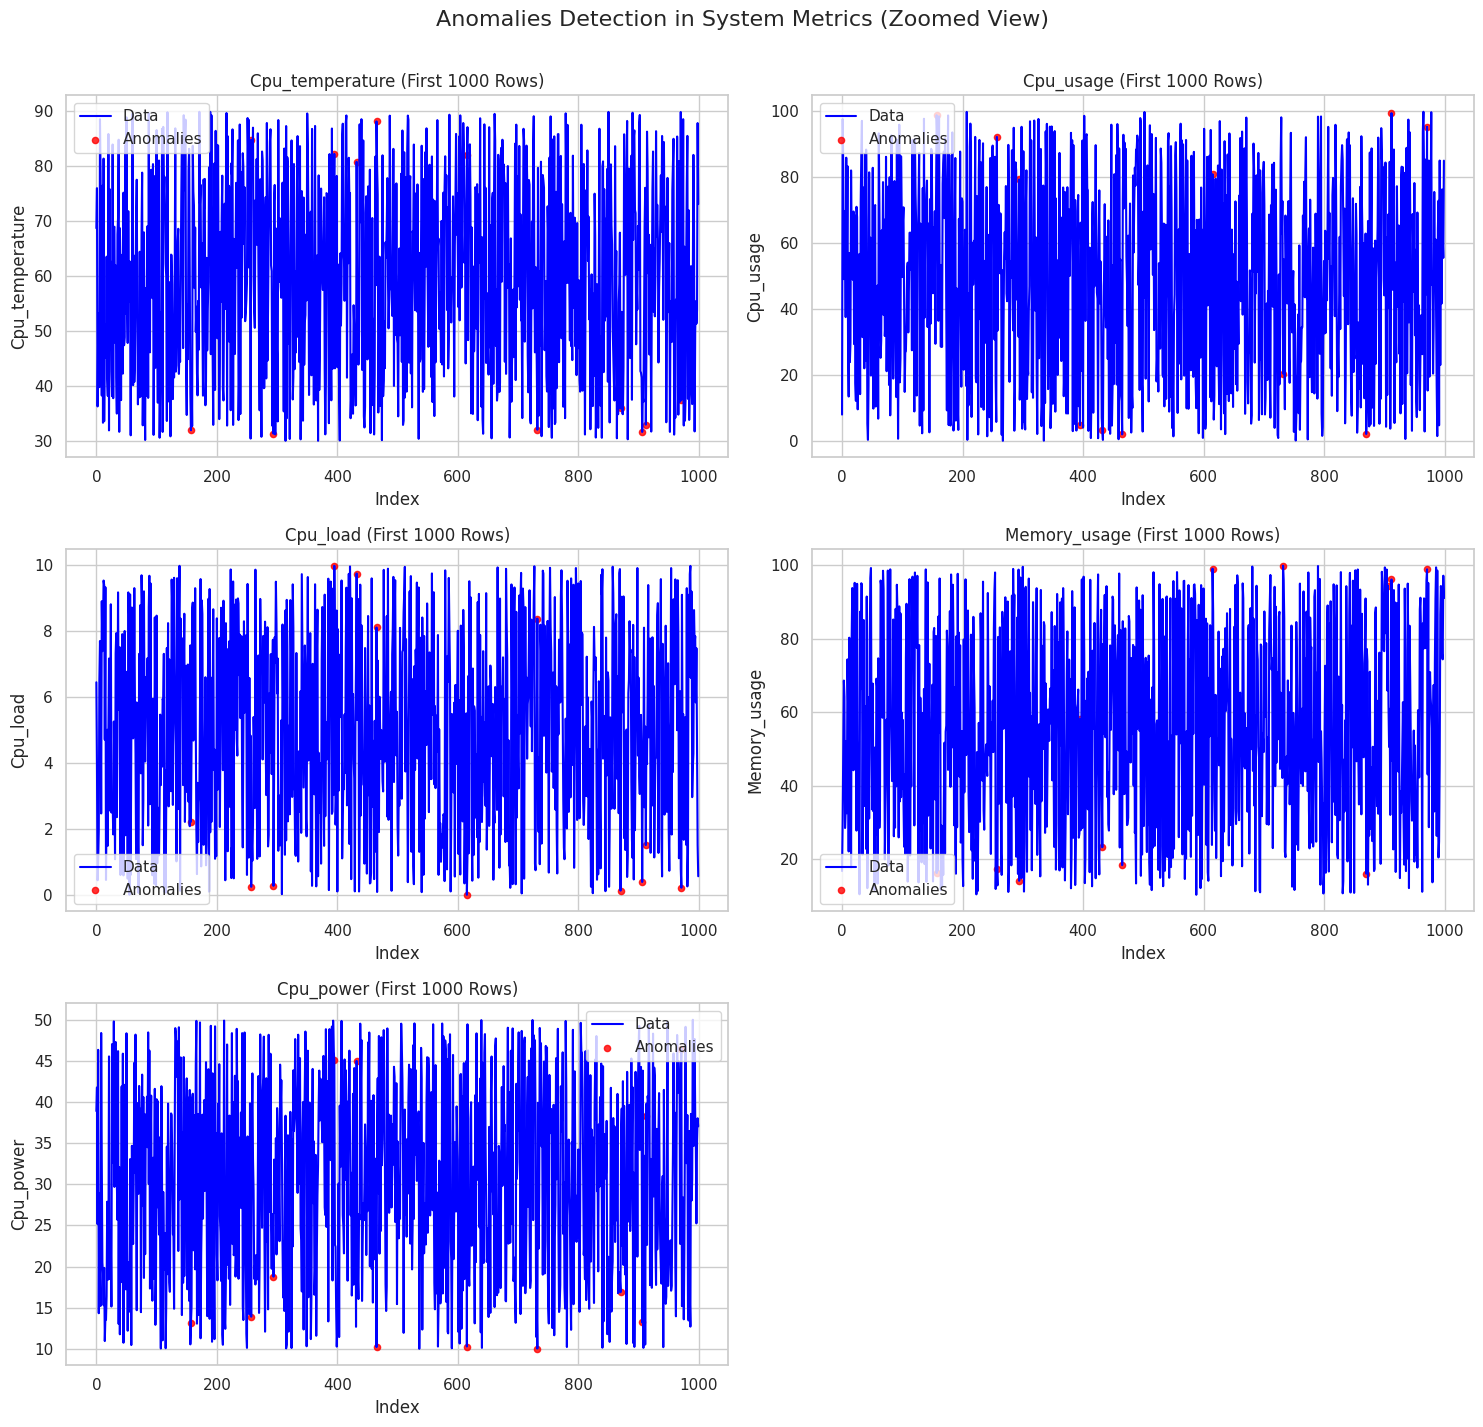

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
# Replace 'hardware_monitor_data.csv' with the correct path to your data
df_pandas = pd.read_csv("hardware_monitor_data.csv")

# Ensure your dataset has the required columns
columns_to_analyze = ['cpu_temperature', 'cpu_usage', 'cpu_load', 'memory_usage', 'cpu_power']

# Check if all required columns are in the data
missing_columns = [col for col in columns_to_analyze if col not in df_pandas.columns]
if missing_columns:
    raise ValueError(f"Missing columns in the dataset: {', '.join(missing_columns)}")

# Drop rows with missing values in the columns to analyze
df_pandas = df_pandas.dropna(subset=columns_to_analyze)

# Initialize IsolationForest model
model = IsolationForest(contamination=0.01, random_state=42)

# Fit the model and predict anomalies
df_pandas['anomaly'] = model.fit_predict(df_pandas[columns_to_analyze])

# Improved visualization
# Filter only the first 1000 rows for clarity in visualization
subset_df = df_pandas.iloc[:1000]

# Create a plot
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Adjust for 5 metrics (3 rows x 2 columns)
axes = axes.flatten()

# Loop through all metrics, including 'cpu_power'
for i, metric in enumerate(columns_to_analyze):
    if i >= len(axes): break  # Prevent index error if more metrics than axes

    ax = axes[i]
    ax.plot(subset_df.index, subset_df[metric], color='blue', label="Data")  # Plot the original data
    anomalies = subset_df[subset_df['anomaly'] == -1]  # Filter anomalies
    ax.scatter(anomalies.index, anomalies[metric], color='red', alpha=0.8, s=20, label="Anomalies")  # Highlight anomalies
    ax.set_title(f"{metric.capitalize()} (First 1000 Rows)")
    ax.set_xlabel("Index")
    ax.set_ylabel(metric.capitalize())
    ax.legend()

# Hide any unused subplots
for j in range(len(columns_to_analyze), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Anomalies Detection in System Metrics (Zoomed View)", fontsize=16)
plt.show()
